In [200]:
!pip install yfinance
!pip install newsapi-python
!pip install pmdarima
!pip install visualize
!pip install pmdarima --user

  Created wheel for visualize: filename=visualize-0.5.1-py3-none-any.whl size=11467 sha256=2435ee1c8e3781900783f3114cfdbff550aa628004b0cc9e4ff8690354aed746
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\9d\06\26\944128c987db913298520c2b476bb652faf6a5d00accb3f59c
Successfully built visualize


In [5]:
import yfinance as yf
from statsmodels.tsa.arima_model import ARIMA
from newsapi import NewsApiClient
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import math
from sklearn.metrics import mean_squared_error

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
def plot_basic(stocks, title='Close Price', y_label='Price USD', x_label='Trading Days'):
    fig, ax = plt.subplots()
    ax.plot(stocks['Close'], '#0A7388')
    ax.set_title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()
    
def plot_prediction(actual, prediction, title='Yahoo Finance vs Prediction', y_label='Price USD', x_label='Trading Days'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    # Plot actual and predicted close values
    plt.plot(actual, '#00FF00', label='Adjusted Close')
    plt.plot(prediction, '#0000FF', label='Predicted Close')
    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()


In [8]:
#### GET STOCK DATA using TICKER YAHOO FINANCE API ####
def get_data_stock(stock_ticker,start_dt,end_dt):

    #define the ticker symbol
    tickerSymbol = stock_ticker

    #get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start=start_dt, end=end_dt)

    #see your data
    tickerDf['Item'] = np.arange(len(tickerDf))
    return tickerDf[['Item','Open', 'Close', 'Volume']]

#### GET NEWS from NEWS API #####
### API KEY : 0b2277b448e44ddbbdb1e4b45dcb8f64 ###

def get_news(stock_ticker):
    api = NewsApiClient(api_key='0b2277b448e44ddbbdb1e4b45dcb8f64')
    j = api.get_everything(q=stock_ticker)
    return j

def get_news_content(stock_ticker):
    news = get_news(stock_ticker)
    for i in news['articles']:
        print(i['title'])



In [9]:
##### Function to normalize the data features ####
def get_normalised_data(data):
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler()
    numerical = ['Open', 'Close', 'Volume']
    data[numerical] = scaler.fit_transform(data[numerical])
    return data

In [10]:
##### GET RMSE ######
def get_rmse(actual,predicted):
    return math.sqrt(mean_squared_error(actual,predicted))

In [11]:
### SCALING DATA ###
def scale_range(x, input_range, target_range):
    range = [np.amin(x), np.amax(x)]
    x_std = (x - input_range[0]) / (1.0*(input_range[1] - input_range[0]))
    x_scaled = x_std * (1.0*(target_range[1] - target_range[0])) + target_range[0]
    return x_scaled, range

In [12]:

##### TRAIN TEST SPLIT FOR LINEAR REGRESSION #####
def train_test_split_linear_regression(stocks):
    # Create numpy arrays for features and targets
    feature = []
    label = []

    # Convert dataframe columns to numpy arrays for scikit learn
    for index, row in stocks.iterrows():
        # print([np.array(row['Item'])])
        feature.append([(row['Item'])])
        label.append([(row['Close'])])
    #print(feature)
    #print(label)

    # Regularize the feature and target arrays and store min/max of input data for rescaling later
    feature_bounds = [min(feature), max(feature)]
    feature_bounds = [feature_bounds[0][0], feature_bounds[1][0]]
    label_bounds = [min(label), max(label)]
    label_bounds = [label_bounds[0][0], label_bounds[1][0]]

    feature_scaled, feature_range = scale_range(np.array(feature), input_range=feature_bounds, target_range=[-1.0, 1.0])
    label_scaled, label_range = scale_range(np.array(label), input_range=label_bounds, target_range=[-1.0, 1.0])

    # Define Test/Train Split 80/20
    split = .20
    split = int(math.floor(len(stocks['Item']) * split))
    ##print(split)
    # Set up training and test sets
    X_train = feature_scaled[:-split]
    X_test = feature_scaled[-split:]

    y_train = label_scaled[:-split]
    y_test = label_scaled[-split:]

    return X_train, X_test, y_train, y_test, label_range
    
    

In [13]:

#### BUILD LINEAR REGRESSION MODEL ####
def Linear_RegressionModel(X,y):
    linear_mod = linear_model.LinearRegression()
    X = np.reshape(X, (X.shape[0], 1))
    y = np.reshape(y, (y.shape[0], 1))
    linear_mod.fit(X, y)  # fitting the data points in the model
    return linear_mod

def Linear_model_predict(model, x, label_range):
    x = np.reshape(x, (x.shape[0], 1))
    #print(x)
    predicted_price = model.predict(x)
    #print(predicted_price)
    predictions_rescaled, re_range = scale_range(predicted_price, input_range=[-1.0, 1.0], target_range=label_range)
    #print(predictions_rescaled)
    return predicted_price.flatten()


In [14]:
### SARIMA MODEL GENERATION ###
def sarima_model(df_train,df_test,p=1,d=1,q=1):
    # Fit auto_arima function
    '''stepwise_fit = auto_arima(df_train['Close'] start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

  
    # To print the summary
    stepwise_fit.summary()
    '''
    model = SARIMAX(df_train['Close'],order = (0, 1, 1),seasonal_order =(2, 1, 1, 30))
    sarima_model = model.fit()
    #print(result.summary())
    start = len(df_train)
    end = len(df_train) + len(df_test) - 1
    df_results = pd.DataFrame()
    indexes = df_test.index
    print(indexes)
    predictions = sarima_model.predict(start, end)
    df_results['Date'] = indexes
    df_results['Forecast'] = pd.DataFrame(predictions).reset_index().loc[:,'predicted_mean']
    df_results['Actual']=df_test.reset_index().loc[:,'Close']
    df_results.set_index('Date',inplace=True)
    ##print(len(df_results),len(indexes))
    ##print(df_results)
    df_results.plot(y=["Actual", "Forecast"], kind="line")
    #predictions.plot(legend = True)
    #df_test['Close'].plot(legend = True)
       

In [15]:

        


##### TRAIN TEST SPLIT FOR LSTM #####
def train_test_split_lstm(stocks,history=60):
    close_price=stocks.filter(['Close']).values
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(close_price)
    train_len = math.ceil(0.8*len(close_price))
    train_data = scaled_data[0:train_len,:]
    test_data = scaled_data[train_len:,:]
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    #### Prepare data for sequential Model Train ####
    for i in range(history,len(train_data)):
        x_train.append(train_data[i-history:i,0])
        y_train.append(train_data[i,0])
        
    #### Prepare data for sequential Model Test ####
    for i in range(history,len(test_data)):
        x_test.append(test_data[i-history:i,0])
        y_test.append(test_data[i,0])
    
    ### convert to numpy array ###
    x_train,y_train = np.array(x_train),np.array(y_train)
    x_test,y_test = np.array(x_test),np.array(y_test)
    
    ### RESHAPE AS expected by LSTM Model (rows,columns,features)
    x_train = np.reshape(x_train,(len(x_train),history,1))
    x_test = np.reshape(x_test,(len(x_test),history,1))
    return x_train,y_train,x_test,y_test,scaler
    
    
    
#### BUILD LSTM MODEL USING KERAS ####
def build_lstm_model(x_train,y_train):
    model = Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(LSTM(50,return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(x_train,y_train,batch_size=1,epochs=1)
    return model

def lstm_tuning(stocks):
    history = [7,15,30]
    rmse = []
    actual_price = []
    predicted_price = []
    #### ITERATE OVER ALL HISTORY ROLLUPS ####
    for i in history:
        x_train,y_train,x_test,y_test,scaler = train_test_split_lstm(stocks,i)
        lstm_model = build_lstm_model(x_train,y_train)
        predictions = lstm_model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)
        actuals = scaler.inverse_transform(np.reshape(y_test,(y_test.shape[0],1)))
        predicted_price.append(predictions)
        actual_price.append(actual_price)
        rmse_tmp = get_rmse(np.array(actuals),np.array(predictions))
        rmse.append(rmse_tmp)
        print("History:"+str(i)+", RMSE:"+str(rmse_tmp))
    
    ### GET MINIMUM RMSE corresponding history for stock
    min_idx = 0;
    min_rmse= rmse[0];
    for i in range(len(rmse)):
        if min_rmse>rmse[i]:
            min_rmse=rmse[i]
            min_idx=i
    
    print('BEST LSTM MODEL IS OBTAINED AT History: '+str(history[min_idx])+' with RMSE:'+str(rmse[min_idx]))
    
    return rmse,history,actual_price,predicted_price,min_idx
        
        

In [16]:
##### TRAIN TEST SPLIT ######
def train_test_split(df,start,end):
    train_set = df_stock.loc['2018-01-01': '2021-01-01']
    train_set
    test_set = df_stock.loc['2021-01-02':]
    test_set
    print(test_set)

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2021-09-17', '2021-09-20', '2021-09-21', '2021-09-22',
               '2021-09-23', '2021-09-24', '2021-09-27', '2021-09-28',
               '2021-09-29', '2021-09-30'],
              dtype='datetime64[ns]', name='Date', length=188, freq=None)


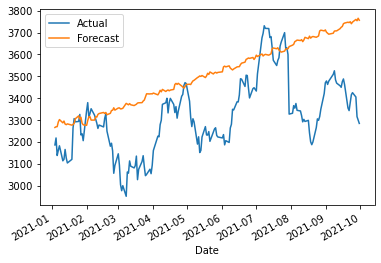

In [17]:
####### START HERE ###
###############################



### SET THE VARIABLES TO extract Data #####
stock_ticker = 'AMZN'
start_dt = '2010-01-01'
end_dt = '2021-10-01'



### GET TICKER DATA ###
df_stock = get_data_stock(stock_ticker,start_dt,end_dt);
print(df_stock)



            Item         Open        Close    Volume
Date                                                
2010-01-04     0   136.250000   133.899994   7599900
2010-01-05     1   133.429993   134.690002   8851900
2010-01-06     2   134.600006   132.250000   7178800
2010-01-07     3   132.009995   130.000000  11030200
2010-01-08     4   130.559998   133.520004   9830500
...          ...          ...          ...       ...
2021-09-24  2952  3402.010010  3425.520020   2116200
2021-09-27  2953  3371.500000  3405.800049   3634500
2021-09-28  2954  3357.709961  3315.959961   4430800
2021-09-29  2955  3322.110107  3301.120117   2562300
2021-09-30  2956  3316.000000  3285.040039   2842400

[2957 rows x 4 columns]


0.6655238088807889


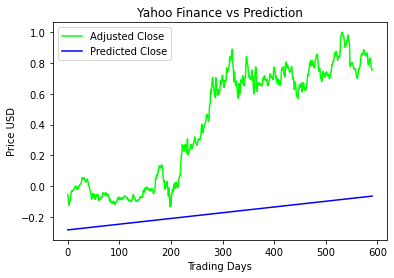

In [344]:



### PLOT STOCK data ###
#plot_basic(df_stock)





### NORMALIZE DATA for STOCK ###




### GENERATE A BASIC LINEAR REGRESSION MODEL ###

x_train,x_test,y_train,y_test,yrange = train_test_split_linear_regression(df_stock)
#print("x_train", x_train)
#print("y_train", y_train)
#print("x_test", x_test)
#print("y_test", y_test)

lm_model = Linear_RegressionModel(x_train,y_train);
predictions = Linear_model_predict(lm_model,x_test,yrange)

### PLOT BASIC LINEAR REGRESSION MODEL RESULTS ###
plot_prediction(y_test,predictions)
print(get_rmse(y_test,predictions))

















In [ ]:


### GENERATE SARIMAX FORECASTING MODEL ###
sarima_model(train_set,test_set)


#### PLOT SARIMAX RESULTS ####


#### CALL SARIMA MODEL ####


In [ ]:

### GENERATE LSTM MODEL ###    
rmse,history,actual_price,predicted_price,min_idx = lstm_tuning(df_stock)

### PLOT LSTM RESULTS for optimized ###
plot_prediction(actual_price[min_idx],predicted_price[min_idx])




2359/2359 [==============================] - 12s 4ms/step - loss: 3.8417e-04
History:7, RMSE:195.31236114861898
2351/2351 [==============================] - 20s 8ms/step - loss: 3.5438e-04
History:15, RMSE:94.72764638169626
2336/2336 [==============================] - 41s 17ms/step - loss: 3.5269e-04 0s - loss: 3.531


In [ ]:
### PLOT LSTM RMSE LOSS CURVE AGAINST History 
plt.plot(history,rmse)
plt.show()